### Import packages

In [2]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
import json
from matplotlib.colors import LogNorm

In [3]:
#root_folder_path = "N:\\durable\\sound-and-ecg\\2024-10-Maja-restructured\\Data"
root_folder_path = "C:\\Users\\MajaE\\src\\repos\\master_ML\\Data"

### Extract data

In [4]:
def post_processing(true, predictions, predictions_proba, segment_size):
    # Find number of observations in the data
    segmented_true = []
    segmented_predictions = []
    segmented_predictions_proba = []

    for i in range(len(true)):
        subject_segmented_true = []
        subject_segmented_predictions = []
        subject_segmented_predictions_proba = []
        for j in range(0,len(true[i])-segment_size):
            # Majority voting for the separate segments
            subsequence_true = int(mode(true[i][j:(j+segment_size)]))
            subsequence_predictions = int(mode(predictions[i][j:(j+segment_size)]))
            subsequence_predictions_proba = np.mean(predictions_proba[i][j:(j+segment_size)])
            subject_segmented_true.append(subsequence_true)
            subject_segmented_predictions.append(subsequence_predictions)
            subject_segmented_predictions_proba.append(subsequence_predictions_proba)
        segmented_true.append(subject_segmented_true)
        segmented_predictions.append(subject_segmented_predictions)
        segmented_predictions_proba.append(subject_segmented_predictions_proba)
    return segmented_true,segmented_predictions, segmented_predictions_proba

In [5]:
def extract_test_parameters(test_file):
    true,predictions,predictions_proba,test_recording_ids,segment_parameters =[],[],[],[],[]
    with open(test_file, 'rb') as handle:
        true,predictions,predictions_proba,test_recording_ids, segment_parameters = pickle.load(handle)
    if segment_parameters[2] == 1:
        true, predictions, predictions_proba = post_processing(true,predictions,predictions_proba,50)
        segment_parameters[2] = 30
    return true,predictions,predictions_proba,test_recording_ids,segment_parameters

### Analyze metrics

In [6]:
def calculate_metrics(true,predictions):
    accuracy = accuracy_score(true, predictions) # ((TN + TP) / (TN + FN + TP + FP))
    precision = precision_score(true, predictions,zero_division=np.nan) # Positive predictive rate -> TP/(TP+FP)
    recall = recall_score(true, predictions,zero_division=np.nan) # Sensitivity -> TP/(TP+FN)
    confusion = confusion_matrix(true,predictions) # Confusion matrix
    f1 = f1_score(true,predictions,zero_division=np.nan,average='macro')
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn+fp)
    return accuracy,recall,specificity,confusion,precision,f1

In [7]:
def visualize_metrics(accuracy,recall,specificity,confusion, precision,f1):
    print("Accuracy: ", accuracy)
    print("Sensitivity: ", recall)
    print("Precision: ", precision)
    print("Specificity: ", specificity)
    print("Macro F1-score:", f1)

    plt.figure()
    sns.heatmap(confusion,annot=True,fmt='d',cmap='Blues',norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.show()

### Plot ROC curve

In [8]:
def find_avg_performance(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    accuracy_vector, specificity_vector, recall_vector, precision_vector, f1_vector = [], [], [], [], []
    for subject_idx in range(len(true)):
        accuracy,recall,specificity,_,precision,f1 = calculate_metrics(true[subject_idx],predictions[subject_idx])
        accuracy_vector.append(accuracy)
        specificity_vector.append(specificity)
        recall_vector.append(recall)
        precision_vector.append(precision)
        f1_vector.append(f1)
    accuracy = np.mean(accuracy_vector)
    specificity = np.nanmean(specificity_vector)
    recall = np.nanmean(recall_vector)
    precision = np.nanmean(precision_vector)
    f1 = np.nanmean(f1_vector)
    true_concatenated = np.concatenate(true,axis=0)
    predictions_concatenated = np.concatenate(predictions,axis=0)
    _,_,_,confusion,_,_ = calculate_metrics(true_concatenated,predictions_concatenated)
    visualize_metrics(accuracy,recall,specificity,confusion,precision,f1)

    return recall, specificity, accuracy, f1 

In [9]:
def ROC_curve(sensitivity, specificity, labels):
    fpr = [1 - sp for sp in specificity]
    distances = [(1-tpr)**2 + (fpr[i])**2 for i,tpr in enumerate(sensitivity)] 
    best_index = distances.index(min(distances))

    plt.figure()
    plt.plot(fpr, sensitivity, label = 'ROC Curve' )

    plt.plot(fpr[best_index], sensitivity[best_index], 'go')
    plt.annotate(f"Shortest distance: {labels[best_index]}", (fpr[best_index], sensitivity[best_index]),xytext=(60,-2),textcoords='offset points',ha='center', va = 'top')

    f1_best_index = 31
    plt.plot(fpr[f1_best_index], sensitivity[f1_best_index], 'ro')
    plt.annotate(f"Highest macro F1-score: {labels[f1_best_index]}", (fpr[f1_best_index], sensitivity[f1_best_index]),xytext=(80,-2),textcoords='offset points',ha='center', va = 'top')

    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'baseline')
    
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curve')
    plt.legend()
    plt.grid(True)
    
plt.show()

In [10]:
def performance_curve(parameter, accuracy, f1, label):
    best_index = f1.index(max(f1))

    plt.figure()
    #plt.plot(parameter,accuracy)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title(f'Performance of {label}')
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(parameter,f1)
    #plt.plot(parameter[best_index], f1[best_index], 'ro')
    plt.annotate(f"Highest macro F1-score: {parameter[best_index]}", (parameter[best_index], f1[best_index]),xytext=(50,10),textcoords='offset points',ha='center', va = 'top')
    print(best_index)
    plt.xlabel('Threshold')
    plt.ylabel('Macro F1-score')
    plt.title(f'Performance of {label}')
    plt.grid(True)
    plt.show()


In [11]:
def extract_test_ROC(root_folder_path):
    sensitivity, specificity, accuracy, f1  = [], [], [], []
    
    data_folder_path = os.path.join(root_folder_path,"data")
    for iteration in os.listdir(data_folder_path):
        iteration_path = os.path.join(data_folder_path,iteration)
        i_sensitivity, i_specificity, i_accuracy, i_f1 = find_avg_performance(iteration_path)
        sensitivity.append(i_sensitivity)
        specificity.append(i_specificity)
        accuracy.append(i_accuracy)
        f1.append(i_f1)

    parameters_path = f"{root_folder_path}\\parameters.json"
    test_values = ""
    with open(parameters_path, 'r') as file:
        meta_data = json.load(file)
        test_values = meta_data["test_values"]
    #ROC_curve(sensitivity, specificity,test_values)
    #performance_curve(test_values, accuracy, f1, "HMM")


Accuracy:  0.8994793964221406
Sensitivity:  0.7867768959435626
Precision:  0.7641318003318429
Specificity:  0.9341471863244107
Macro F1-score: 0.8477868703112889


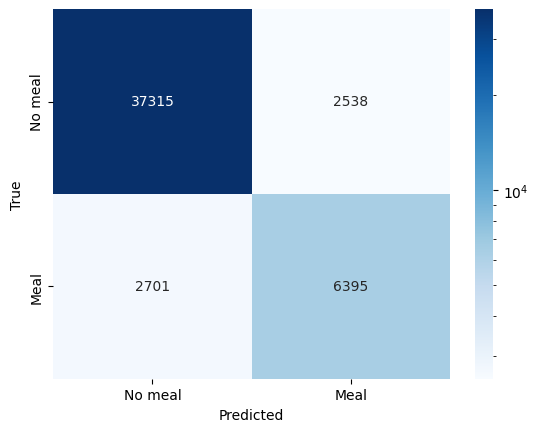

Accuracy:  0.8892530949868653
Sensitivity:  0.6749761484411803
Precision:  0.6822275681951246
Specificity:  0.9422469073848
Macro F1-score: 0.7953455662942782


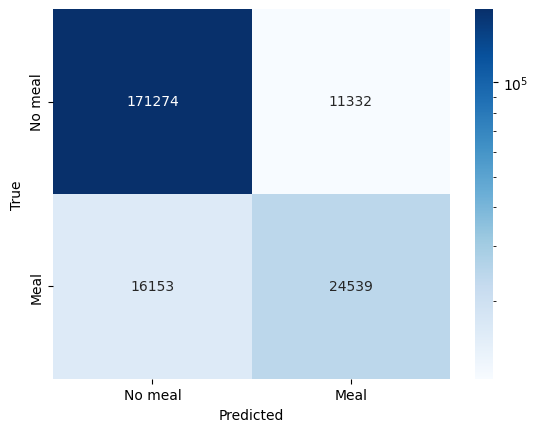

In [12]:
classes = ['No meal','Meal']
test_name = "LDA_test"
extract_test_ROC(test_name)

### Plot evolution of predictions

In [13]:
def calculate_seconds_between_the_subsequences(segment_parameters):
    [segment_length,overlap_length,n_segments] = segment_parameters
    step_length = segment_length - overlap_length
    subsequence_length = n_segments*step_length
    return step_length, subsequence_length

In [14]:
def find_meta_data(id):
    # Loop through each academic year in data folder
    root_folder_path_os = os.path.abspath(root_folder_path)
    for year_folder in os.listdir(root_folder_path_os):
        year_folder_path = os.path.join(root_folder_path_os,year_folder)
        # Ensure directory (folder)
        if os.path.isdir(year_folder_path): 
            # Loop through each subject in year
            for subject_folder in os.listdir(year_folder_path):
                subject_folder_path = os.path.join(year_folder_path,subject_folder)
                # Ensure directory (folder)
                if os.path.isdir(subject_folder_path): 
                    # Loop through each recording for subject
                    for recording_folder in os.listdir(subject_folder_path):
                        recording_folder_path = os.path.join(subject_folder_path,recording_folder)
                        if recording_folder == id:
                            if os.path.isdir(recording_folder_path):
                                metadata_file_path = os.path.join(recording_folder_path, f"{recording_folder}.json")
                                return metadata_file_path
    return None

In [15]:
def find_disturbances(id):
    id_file = find_meta_data(id)

    # Extract labels from metadata files
    meta_data = ""
    audio_offset = 0
    with open(id_file, 'r') as file:
        meta_data = json.load(file)
    if "audio_offset" in meta_data:
        audio_offset = meta_data["audio_offset"]
    disturbances = []
    disturbances.append((meta_data["mealStart"]-audio_offset,meta_data["mealEnd"]-audio_offset,'meal'))
    meal_type = meta_data["mealType"]

    if "disturbances" in meta_data:
        for disturbance in meta_data["disturbances"]:
            disturbances.append((disturbance["start"]-audio_offset,disturbance["end"]-audio_offset,disturbance["type"]))
    return disturbances, meal_type
    

In [16]:
def plot_evolution(true,predictions,disturbances,meal_type,step_length,subsequence_length,id):
    time = np.linspace(subsequence_length,len(true)*step_length,len(true))
    label_color_map = {
        'meal': 'green',
        'phys_activity': 'red',
        'move_leads': 'red',
        'rub_mic': 'red',
        'drink_water': 'red',
        'talking': 'red'
    }

    min_value = min(min(true), min(predictions))
    max_value = max(max(true), max(predictions))

    plt.figure()
    for idx, (start, end, type) in enumerate(disturbances):
        color = label_color_map[type]
        plt.axvspan(start, end, color=color, alpha=0.3)
        plt.text((start+end)/2, max_value + 0.07, s=type, ha='center', va='bottom',fontsize=10,color=color, rotation = 330)
    plt.plot(time,predictions,color='k',linestyle='-',label='Predicted')
    #plt.plot(time, [0.5]*len(time), linestyle = '--', color = 'gray', label = 'baseline')
    plt.ylim(min_value,max_value+0.05)
    plt.xlabel('Time [s]')
    plt.text(time[-1],min_value-0.2,f'Recording id: {id}',ha='right',va='bottom')
    plt.text(time[-1],min_value-0.3,f'Meal type: {meal_type}',ha='right',va='bottom')
    plt.tight_layout()
    plt.legend()

    detection_time = np.nan
    (start,end,type) = disturbances[0]
    for idx, time_instance in enumerate(time):
        if time_instance>end:
            break
        elif time_instance>start:
            if predictions[idx] == 1:
                detection_time = time_instance - start
                break
        
    return detection_time


In [17]:
def find_evolution_parameters(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], [] 
    for test_file in test_files:
        true_subject,predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    step_length, subsequence_length = calculate_seconds_between_the_subsequences(segment_parameters[0])

    detection_times = []
    for subject_idx in range(len(true)):
        disturbances, meal_type = find_disturbances(ids[subject_idx])
        detection_time = plot_evolution(true[subject_idx],predictions[subject_idx],disturbances,meal_type,step_length,subsequence_length,ids[subject_idx])
        detection_times.append(detection_time)
    avg_detection_times = np.nanmean(detection_times)
    print('Average detection time:', avg_detection_times)

Average detection time: 10.018934004683071


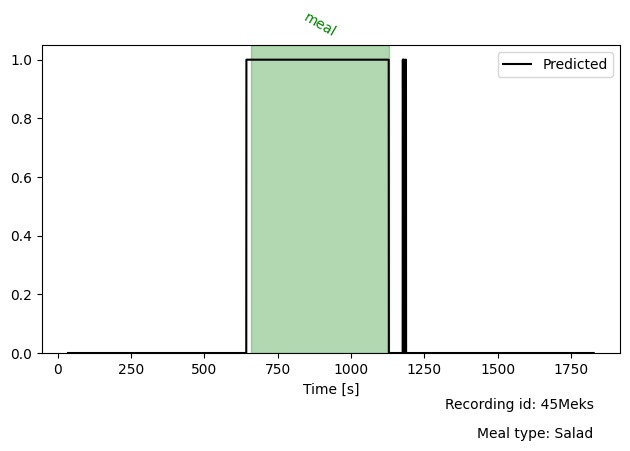

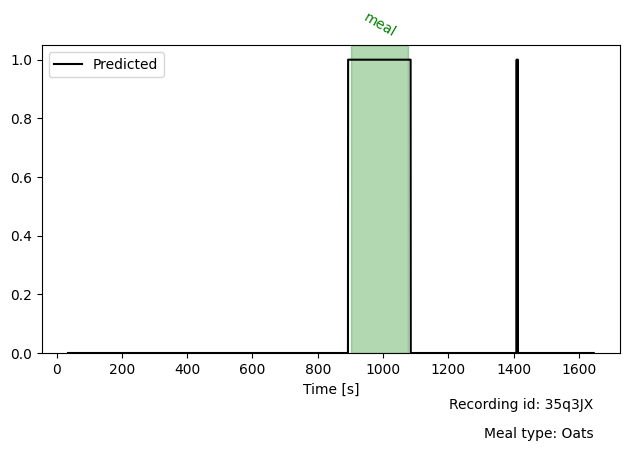

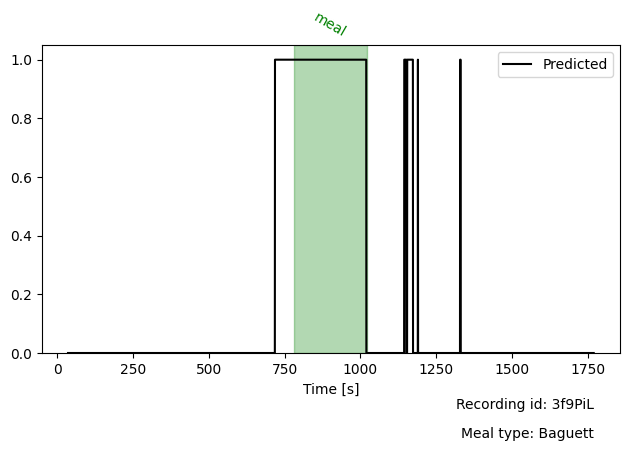

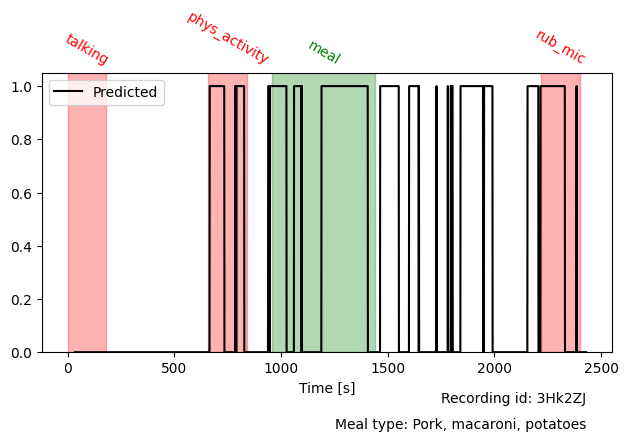

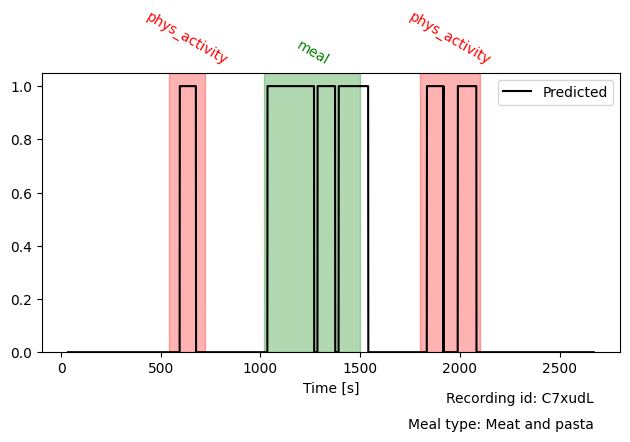

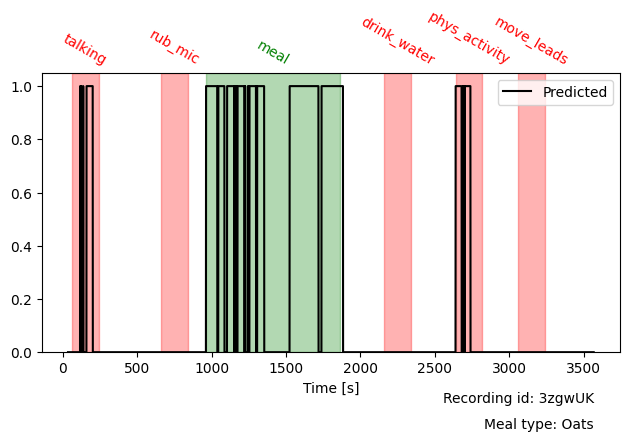

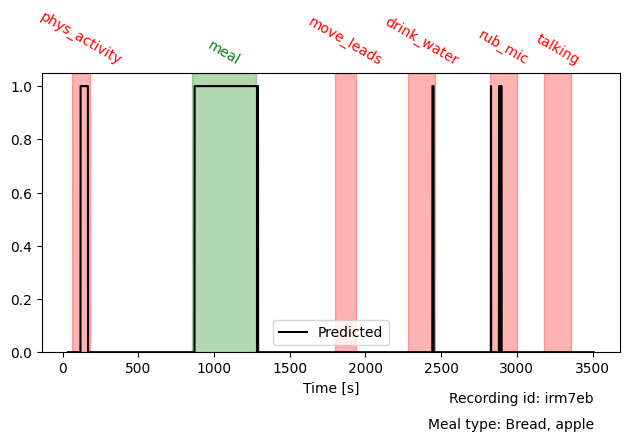

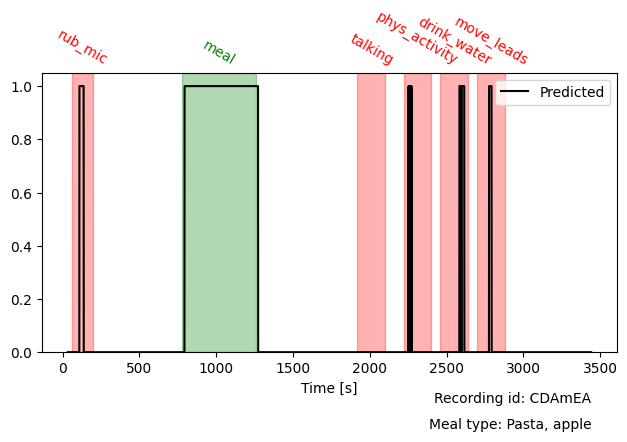

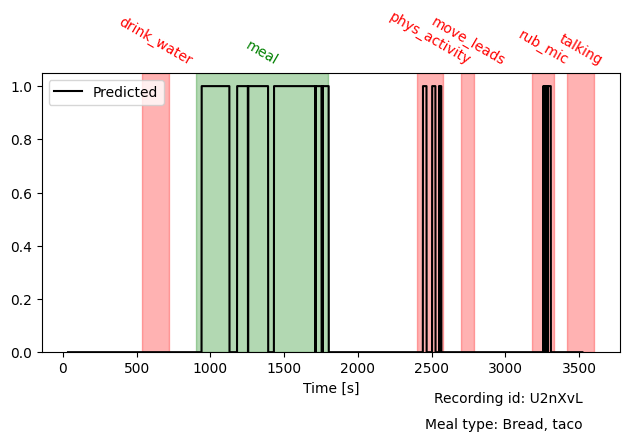

In [18]:
#folder_path = "HMM_validation\\data\\20250607_100948"
folder_path = "HMM_test\\data\\20250612_192429"

find_evolution_parameters(folder_path)